In [1]:
# imports
import numpy as np
from numpy.lib.stride_tricks import as_strided
import cupy as cp
from scipy import signal, misc

import math
import time
import importlib

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Create - Data, Consts, Pars, Lower Bound, Upper Bound

In [2]:
nparam = 4

slice_start = 15
slice_stop = 35

# Data
data = None
with open('data_ivim.npy', 'rb') as f:
    data = np.load(f)[:,:,slice_start:slice_stop,:]
nvoxels = data.shape[0] * data.shape[1] * data.shape[2]
ndata = data.shape[3]
data_flat = data.flatten().reshape((1, ndata*nvoxels), order='C')

# Consts
consts = None
with open('bvals_ivim.npy', 'rb') as f:
    consts = np.load(f)
consts_flat = np.empty((1, ndata*nvoxels), dtype=np.float32)
for i in range(0,ndata):
    consts_flat[:,i::21] = consts[i]

# Pars
pars_dipy = None
with open('pars_ivim_dipytrr.npy', 'rb') as f:
    pars_dipy = np.load(f)[:,:,slice_start:slice_stop,:]
pars_flat = np.transpose(pars_dipy, (3,0,1,2)).reshape((nparam,nvoxels),order='C')


lower_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
lower_bound[0,:] = np.finfo(np.float32).min
lower_bound[1,:] = 0.0
lower_bound[2,:] = 0.0
lower_bound[3,:] = 0.0

upper_bound = cp.empty((4, nvoxels), dtype=np.float32)
upper_bound[0,:] = np.finfo(np.float32).max / 2
upper_bound[1,:] = 1.0
upper_bound[2,:] = 1.0
upper_bound[3,:] = 1.0

In [3]:
import cuda.lsqnonlin as clsq
importlib.reload(clsq)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

nchunks = 1
chunk_size = math.ceil(nvoxels / nchunks)

first_f = np.empty((1, nvoxels), dtype=np.float32)
last_f = np.empty((1, nvoxels), dtype=np.float32)

solm = clsq.SecondOrderLevenbergMarquardt(expr, pars_str, consts_str, ndata=21, dtype=cp.float32, write_to_file=True)

start = time.time()
for i in range(0,nchunks):

	parscu = cp.array(pars_flat[:,i*chunk_size:(i+1)*chunk_size], dtype=cp.float32, copy=True)
	constscu = cp.array(consts_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata], dtype=cp.float32, copy=True)
	datacu = cp.array(data_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata], dtype=cp.float32, copy=True)
	lower_bound_cu = cp.array(lower_bound[:,i*chunk_size:(i+1)*chunk_size], dtype=cp.float32, copy=True)
	upper_bound_cu = cp.array(upper_bound[:,i*chunk_size:(i+1)*chunk_size], dtype=cp.float32, copy=True)

	solm.setup(parscu, constscu, datacu, lower_bound_cu, upper_bound_cu)
	solm.run(50, 1e-5)
	
	first_f[:,i*chunk_size:(i+1)*chunk_size] = solm.first_f.get()
	last_f[:,i*chunk_size:(i+1)*chunk_size] = solm.last_f.get()

	pars_flat[:,i*chunk_size:(i+1)*chunk_size] = parscu.get()

cp.cuda.stream.get_current_stream().synchronize()
end = time.time()
print('It took: ' + str(end - start) + ' s')



It took: 3.654500722885132 s


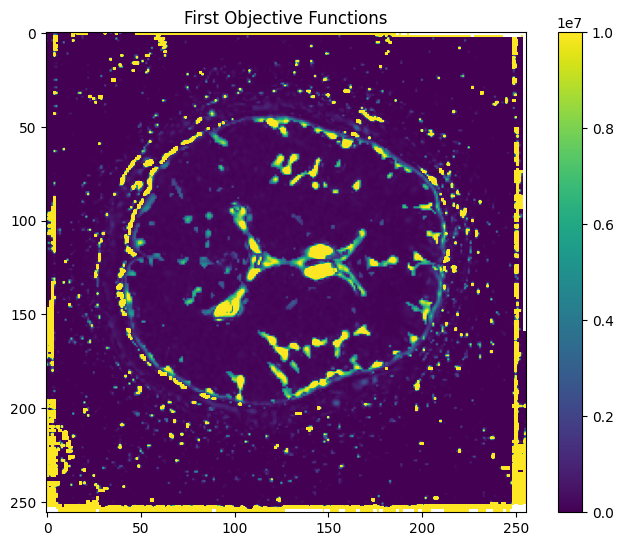

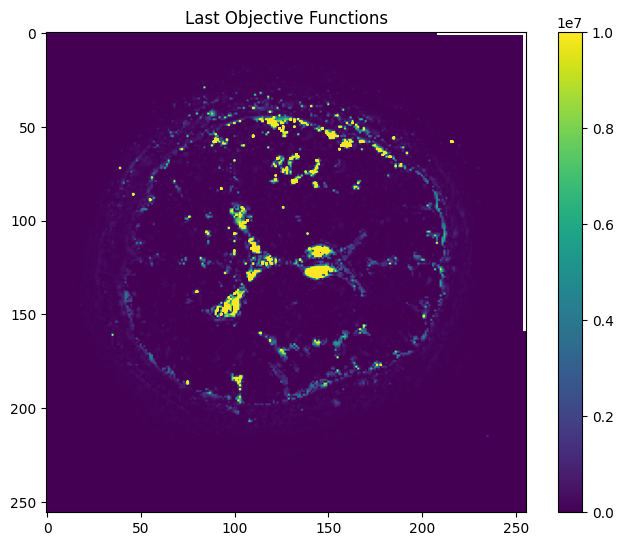

In [4]:
ffig1 = plt.figure()
fax1 = ffig1.add_axes([0,0,1,1])
ffigdata1 = fax1.imshow(np.reshape(first_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,15])
fax1.set_title('First Objective Functions')
ffigdata1.set_clim(0.0, 1e7)
ffig1.colorbar(ffigdata1, ax=fax1)

ffig2 = plt.figure()
fax2 = ffig2.add_axes([0,0,1,1])
ffigdata2 = fax2.imshow(np.reshape(last_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,15])
fax2.set_title('Last Objective Functions')
ffigdata2.set_clim(0.0, 1e7)
ffig2.colorbar(ffigdata2, ax=fax2)

In [5]:
pars_flat_back = np.transpose(np.reshape(pars_flat, (4, data.shape[0], data.shape[1], data.shape[2])), (1,2,3,0))


In [11]:
gemask = pars_flat_back[:,:,:,2] < pars_flat_back[:,:,:,3]

temp = pars_flat_back[gemask, 2].copy()
pars_flat_back[gemask, 2] = pars_flat_back[gemask, 3].copy()
pars_flat_back[gemask, 3] = temp.copy()
pars_flat_back[gemask, 1] = 1 - pars_flat_back[gemask, 1]


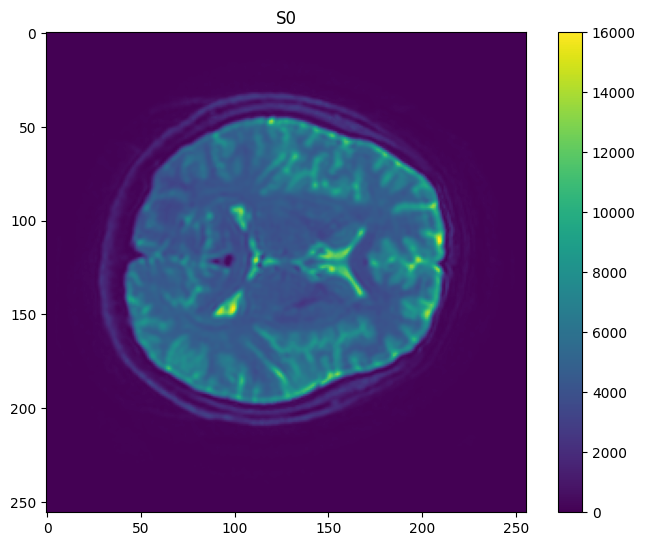

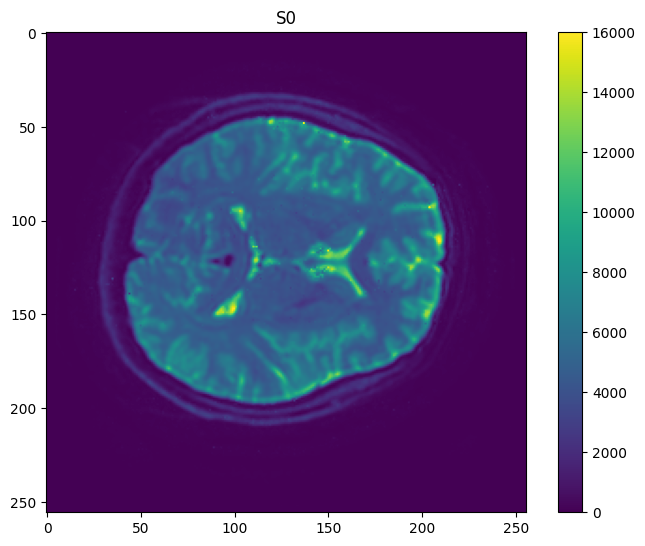

In [12]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], print_S0=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], print_S0=True)


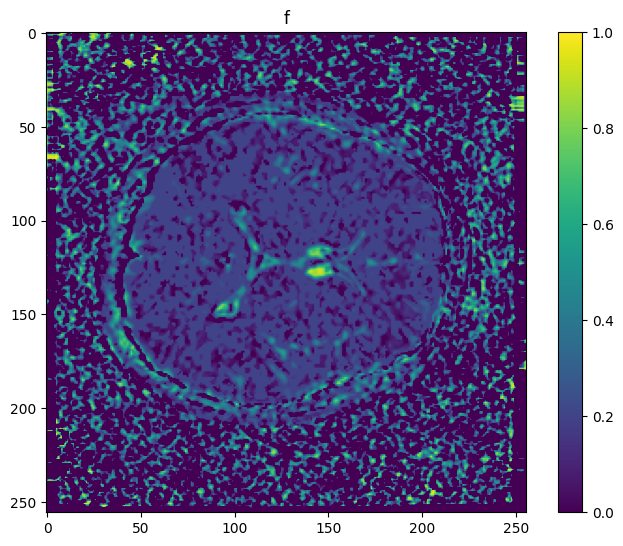

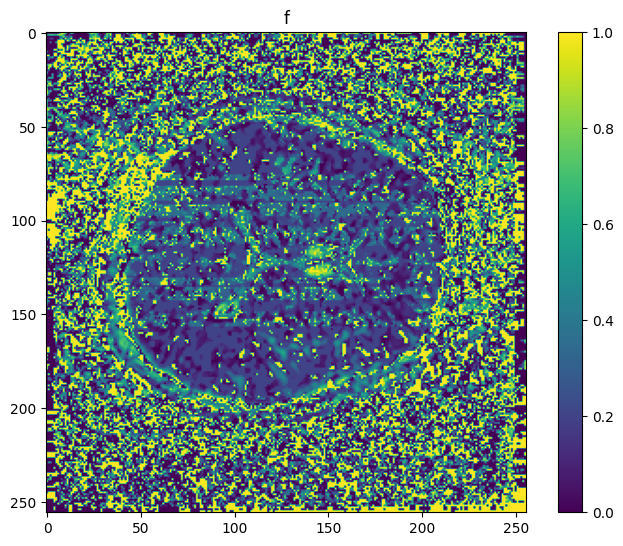

In [13]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_f=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_f=True)


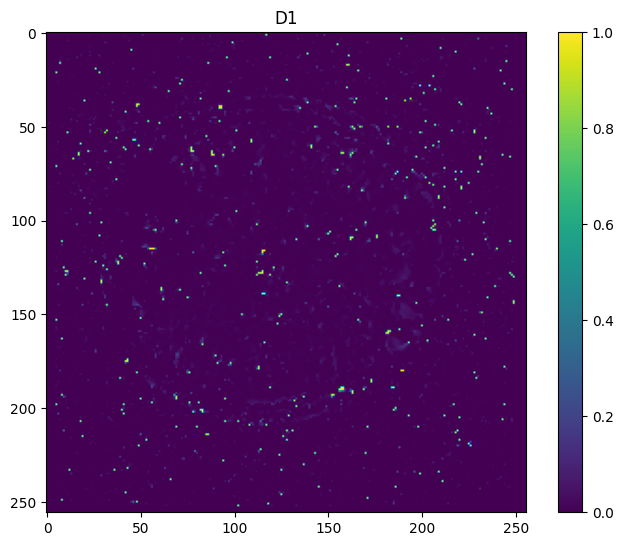

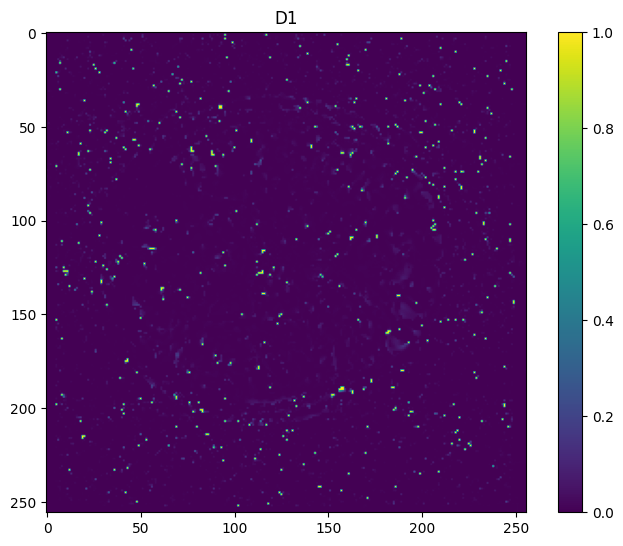

In [14]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D1=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D1=True)


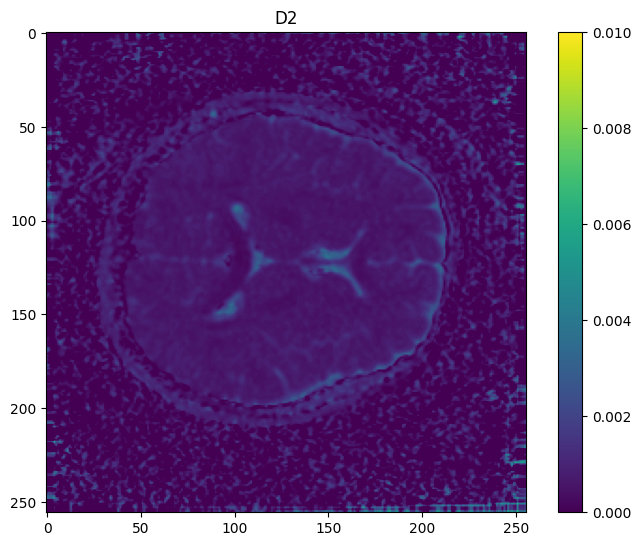

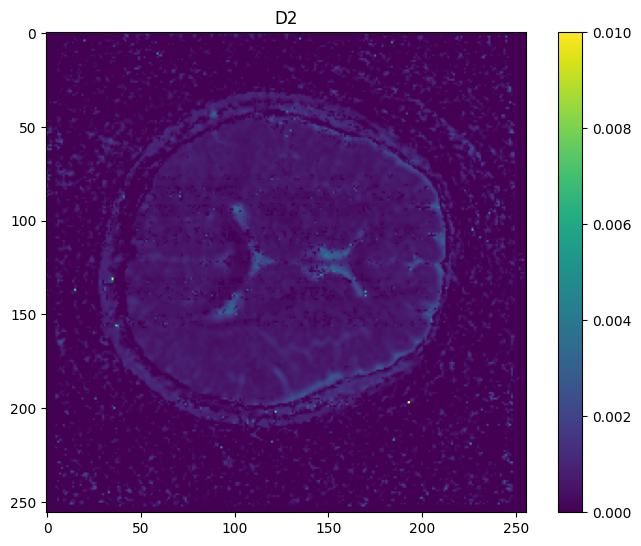

In [15]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D2=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D2=True)
